# Modele de regression supervisé

In [1]:
#pip install "pandas=2.2.2"

In [2]:
import pandas as pd

## Chargement des données

In [3]:
df = pd.read_csv('appartements_data.csv')

### Verification du type et de la structure du DataFrame

In [4]:
df.head()

,title,price,city_name,salon,nb_rooms,nb_baths,surface_area,equipment,link
0,CMN-MA-1752 - Appartement à vendre à Palmier,2 000 000 DH,Casablanca,NaN,2.0,2.0,168.0,Ascenseur/Balcon/Parking/Terrasse,https://www.avito.ma/fr/palmier/appartements/C...
1,66370-Vente Appt à Casablanca Hay Hassani de 1...,1 195 000 DH,Casablanca,NaN,2.0,2.0,98.0,Ascenseur/Balcon/Chauffage/Climatisation/Cuisi...,https://www.avito.ma/fr/hay_hassani/appartemen...
2,Appartement à vendre 81 m² à Dar Bouazza,1 350 000 DH,Dar Bouazza,1.0,2.0,2.0,81.0,Ascenseur/Balcon/Chauffage/Climatisation/Conci...,https://www.avito.ma/fr/dar_bouazza/appartemen...
3,63860-Vente Appt à Casablanca Quartier Bd Med ...,900 000 DH,Casablanca,NaN,1.0,1.0,56.0,Ascenseur/Chauffage/Climatisation/Cuisine Équi...,https://www.avito.ma/fr/centre_ville/apparteme...
4,Appartement à Rabat Agdal,3 100 000 DH,Rabat,2.0,3.0,2.0,200.0,Ascenseur/Balcon/Concierge/Parking/Sécurité,https://www.avito.ma/fr/agdal/appartements/App...


In [5]:
df_sous = df.head().copy()

# Analyse exploratoire des données

In [6]:
df_sous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         5 non-null      object 
 1   price         5 non-null      object 
 2   city_name     5 non-null      object 
 3   salon         2 non-null      float64
 4   nb_rooms      5 non-null      float64
 5   nb_baths      5 non-null      float64
 6   surface_area  5 non-null      float64
 7   equipment     5 non-null      object 
 8   link          5 non-null      object 
dtypes: float64(4), object(5)
memory usage: 492.0+ bytes


In [7]:
df_sous.size

45

## Verification des duplications

In [8]:
df_sous.duplicated().sum()

np.int64(0)

## Identification des valeurs manquantes

In [9]:
df_sous.isna().any(axis=1).sum()

np.int64(3)

## Analyser la distribution des variables numeriques

In [10]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

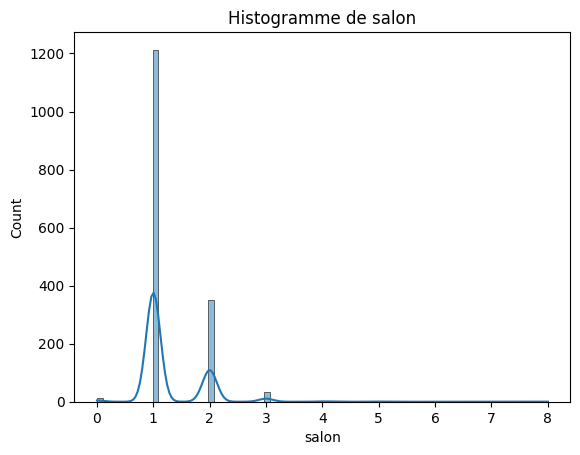

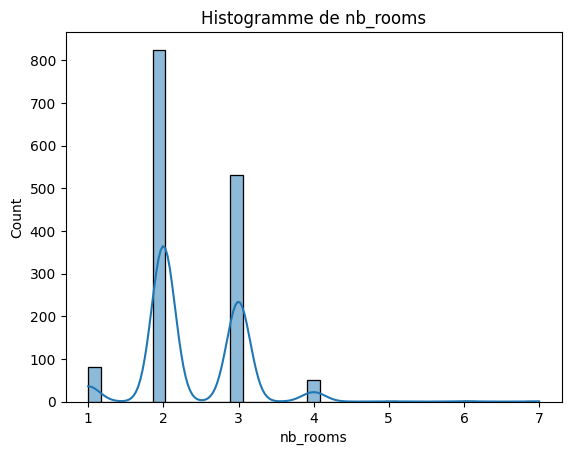

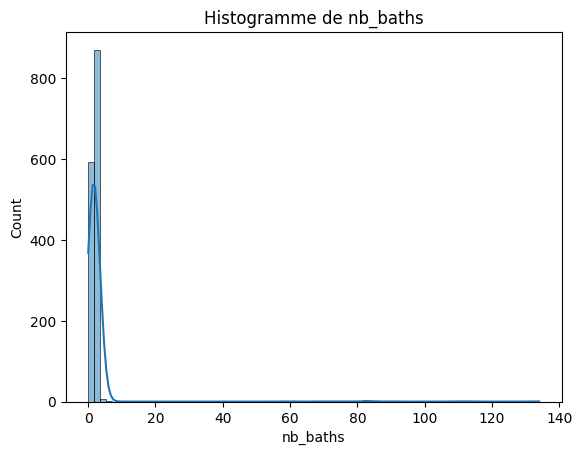

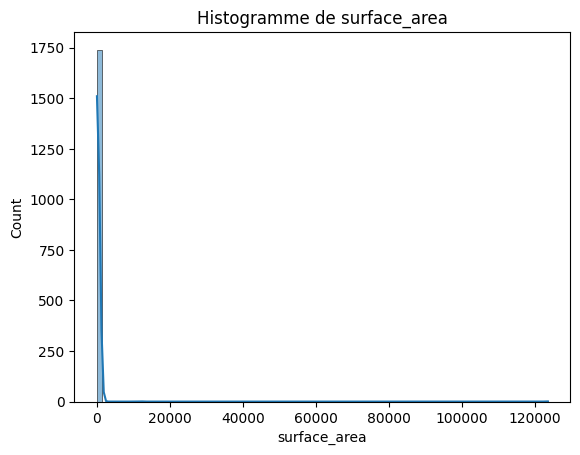

In [12]:
for i in list(df.select_dtypes(include='number').columns):
    sns.histplot(df[i], kde=True)
    plt.title(f'Histogramme de {i}')
    plt.show()

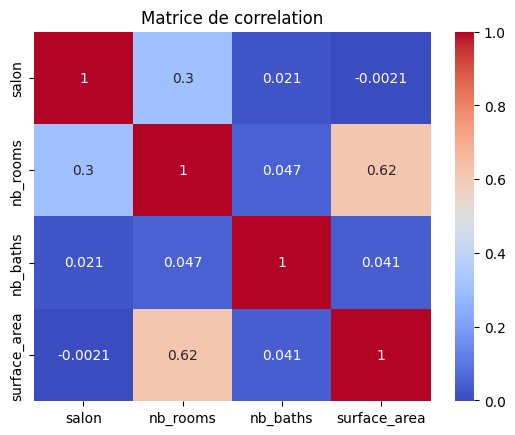

In [13]:
corr = df.corr(numeric_only = True)
sns.heatmap(corr, annot = True, cmap="coolwarm")
plt.title("Matrice de correlation")
plt.show()

# Prétraitement des données

## Etraction des equipements(equipement) dans les colonnes booléeenne

In [14]:
equipement_dummies = df_sous["equipment"].str.get_dummies(sep='/')
df_sous = pd.concat([df_sous, equipement_dummies], axis=1)

## Convertion de la colonne price en type float et suppression des caractères non numérique

In [15]:
df_sous["price"] = (df["price"].astype(str).str.replace(r'[^\d]',"", regex=True).replace("", None).astype(float))

##  Supprission les colonnes inutiles telles que equipment et link.

In [16]:
df_droped = df_sous.drop(columns = {"equipment", "link"} , axis=1)

## Traitement de la colonne city_name

In [17]:
df["city_name"].unique()

array(['Casablanca', 'Dar Bouazza', 'Rabat', 'Marrakech', 'Asilah',
       'Bouskoura', 'Kénitra', 'Mohammedia', 'Agadir', 'Tamesna', 'Salé',
       'Had Soualem', 'Temara', 'Benslimane', 'Tanger', 'Bouznika',
       'Meknès', 'Fès', 'El Jadida', 'El Mansouria', 'Martil',
       'الدار البيضاء', 'Fnideq', 'Tétouan', 'Saidia', 'Nouaceur',
       'القنيطرة', 'Tamaris', 'طنجة', 'Cabo Negro',
       'Sidi Allal El Bahraoui', 'Béni Mellal', 'أكادير', nan,
       'Essaouira', 'Mehdia', 'المحمدية', 'Oujda', 'Oued Laou', 'Dcheira',
       'Sidi Rahal', 'Deroua', 'مراكش', 'Ain Attig', 'Safi', 'الرباط',
       'Inzegan', 'Ifrane', 'Dakhla', 'Dcheïra El Jihadia', 'Taghazout',
       'Sidi Bouknadel', 'Skhirat', 'Khouribga', 'Berkane',
       'Mers El Kheir', 'Berrechid', 'Tiznit', 'Agadir Melloul', 'Nador',
       'El Menzeh', 'Bni Ansar', 'Mdiq', 'Tit Mellil', 'Souk El Arbaa',
       'Biougra', 'Settat', 'Ain Aouda', 'Taza', 'Khemisset', 'Oued Zem',
       'Sefrou', 'Merzouga', 'El Hajeb', 'Selo

In [18]:
villes_dict_ar_fr = {
    "الدار البيضاء": "Casablanca",
    "دار بوعزة": "Dar Bouazza",
    "الرباط": "Rabat",
    "مراكش": "Marrakech",
    "أصيلة": "Asilah",
    "بوسكورة": "Bouskoura",
    "القنيطرة": "Kénitra",
    "المحمدية": "Mohammédia",
    "أكادير": "Agadir",
    "تامسنا": "Tamesna",
    "سلا": "Salé",
    "حد السوالم": "Had Soualem",
    "تمارة": "Temara",
    "بنسليمان": "Benslimane",
    "طنجة": "Tanger",
    "بوزنيقة": "Bouznika",
    "مكناس": "Meknès",
    "فاس": "Fès",
    "الجديدة": "El Jadida",
    "المنصورية": "El Mansouria",
    "مرتيل": "Martil",
    "الفنيدق": "Fnideq",
    "تطوان": "Tétouan",
    "السعيدية": "Saidia",
    "النواصر": "Nouaceur",
    "تماريس": "Tamaris",
    "الكابو نيغرو": "Cabo Negro",
    "سيدي علال البحراوي": "Sidi Allal El Bahraoui",
    "بني ملال": "Béni Mellal",
    "الصويرة": "Essaouira",
    "المهدية": "Mehdia",
    "وجدة": "Oujda",
    "واد لاو": "Oued Laou",
    "الدشيرة": "Dcheira",
    "سيدي رحال": "Sidi Rahal",
    "الدروا": "Deroua",
    "عين عتيق": "Ain Attig",
    "آسفي": "Safi",
    "إنزكان": "Inzegan",
    "إفران": "Ifrane",
    "الداخلة": "Dakhla",
    "الدشيرة الجهادية": "Dcheïra El Jihadia",
    "تغازوت": "Taghazout",
    "سيدي بوقنادل": "Sidi Bouknadel",
    "الصخيرات": "Skhirat",
    "خريبكة": "Khouribga",
    "بركان": "Berkane",
    "مرسى الخير": "Mers El Kheir",
    "برشيد": "Berrechid",
    "تزنيت": "Tiznit",
    "أكادير ملول": "Agadir Melloul",
    "الناظور": "Nador",
    "المنزه": "El Menzé",
    "بني أنصار": "Bni Ansar",
    "المضيق": "Mdiq",
    "تيت مليل": "Tit Mellil",
    "سوق الأربع": "Souk El Arbaa",
    "بيوجرا": "Biougra",
    "سطات": "Settat",
    "عين عودة": "Ain Aouda",
    "تازة": "Taza",
    "الخميسات": "Khemisset",
    "واد زم": "Oued Zem",
    "صفرو": "Sefrou",
    "مرزوكة": "Merzouga",
    "الحاجب": "El Hajeb",
    "سلوان": "Selouane",
    "تاونات": "Taounate",
    "سيدي بنور": "Sidi Bennour",
    "القسيبة": "El Ksiba"
}
df["city_name_fr"] = df["city_name"].str.strip().map(villes_dict_ar_fr).fillna(df["city_name"])

In [19]:
df["city_name_fr"].unique()

array(['Casablanca', 'Dar Bouazza', 'Rabat', 'Marrakech', 'Asilah',
       'Bouskoura', 'Kénitra', 'Mohammedia', 'Agadir', 'Tamesna', 'Salé',
       'Had Soualem', 'Temara', 'Benslimane', 'Tanger', 'Bouznika',
       'Meknès', 'Fès', 'El Jadida', 'El Mansouria', 'Martil', 'Fnideq',
       'Tétouan', 'Saidia', 'Nouaceur', 'Tamaris', 'Cabo Negro',
       'Sidi Allal El Bahraoui', 'Béni Mellal', nan, 'Essaouira',
       'Mehdia', 'Mohammédia', 'Oujda', 'Oued Laou', 'Dcheira',
       'Sidi Rahal', 'Deroua', 'Ain Attig', 'Safi', 'Inzegan', 'Ifrane',
       'Dakhla', 'Dcheïra El Jihadia', 'Taghazout', 'Sidi Bouknadel',
       'Skhirat', 'Khouribga', 'Berkane', 'Mers El Kheir', 'Berrechid',
       'Tiznit', 'Agadir Melloul', 'Nador', 'El Menzeh', 'Bni Ansar',
       'Mdiq', 'Tit Mellil', 'Souk El Arbaa', 'Biougra', 'Settat',
       'Ain Aouda', 'Taza', 'Khemisset', 'Oued Zem', 'Sefrou', 'Merzouga',
       'El Hajeb', 'Selouane', 'Taounate', 'Sidi Bennour', 'El Ksiba'],
      dtype=object)

## Remplacement des valeurs manquantes dans city_name par "Unknown".

In [20]:
if df_droped["city_name"].isna().any(axis=0).sum() > 0:
    df_droped["city_name"] = df_droped["city_name"].fillna("Unknown")

## Gestion des valeurs manquantes:

## Remplacement les valeurs manquantes par la médiane.

In [21]:
for i in list(df_droped.select_dtypes(include="number").columns):
    df_droped[i] = df_droped[i].fillna(df_droped[i].median())

In [22]:
df_droped.head()

,title,price,city_name,salon,nb_rooms,nb_baths,surface_area,Ascenseur,Balcon,Chauffage,Climatisation,Concierge,Cuisine Équipée,Duplex,Meublé,Parking,Sécurité,Terrasse
0,CMN-MA-1752 - Appartement à vendre à Palmier,2000000.0,Casablanca,1.5,2.0,2.0,168.0,1,1,0,0,0,0,0,0,1,0,1
1,66370-Vente Appt à Casablanca Hay Hassani de 1...,1195000.0,Casablanca,1.5,2.0,2.0,98.0,1,1,1,1,0,1,0,0,1,0,0
2,Appartement à vendre 81 m² à Dar Bouazza,1350000.0,Dar Bouazza,1.0,2.0,2.0,81.0,1,1,1,1,1,1,1,0,1,1,1
3,63860-Vente Appt à Casablanca Quartier Bd Med ...,900000.0,Casablanca,1.5,1.0,1.0,56.0,1,0,1,1,0,1,0,1,1,1,1
4,Appartement à Rabat Agdal,3100000.0,Rabat,2.0,3.0,2.0,200.0,1,1,0,0,1,0,0,0,1,1,0


## Pour les colonnes catégorielles (chaînes de caractères) : imputer avec "Unknown"

In [23]:
for i in df_droped.select_dtypes(include="object").columns:
    df_droped[i] = df_droped[i].fillna("Unkown")

# Détection et suppression des valeurs aberrantes:

## Détection les outliers avec la methode statistique IQR

In [24]:
def outliers(dframe):
    outlier_ = {}
    for i in list(dframe.select_dtypes(include="number").columns):
        q1 = dframe[i].quantile(0.25)
        q3 = dframe[i].quantile(0.75)
        IQR = q1 - q3
        b_basse = q1 - 1.5*IQR
        b_haute = q3 + 1.5*IQR
        outliers = dframe[(dframe[i] < b_basse) | (dframe[i] > b_haute)]

    if not outliers.empty:
        outlier_ = outliers
    return outlier_
 
outliers(df_droped)

,title,price,city_name,salon,nb_rooms,nb_baths,surface_area,Ascenseur,Balcon,Chauffage,Climatisation,Concierge,Cuisine Équipée,Duplex,Meublé,Parking,Sécurité,Terrasse
0,CMN-MA-1752 - Appartement à vendre à Palmier,2000000.0,Casablanca,1.5,2.0,2.0,168.0,1,1,0,0,0,0,0,0,1,0,1
1,66370-Vente Appt à Casablanca Hay Hassani de 1...,1195000.0,Casablanca,1.5,2.0,2.0,98.0,1,1,1,1,0,1,0,0,1,0,0
2,Appartement à vendre 81 m² à Dar Bouazza,1350000.0,Dar Bouazza,1.0,2.0,2.0,81.0,1,1,1,1,1,1,1,0,1,1,1
3,63860-Vente Appt à Casablanca Quartier Bd Med ...,900000.0,Casablanca,1.5,1.0,1.0,56.0,1,0,1,1,0,1,0,1,1,1,1
4,Appartement à Rabat Agdal,3100000.0,Rabat,2.0,3.0,2.0,200.0,1,1,0,0,1,0,0,0,1,1,0


## Suppression des lignes contenant des valeurs aberrantes sur des colonnes clés

In [25]:
def drop_outliers(dframe):
    outlier_ = {}
    for i in list(dframe.select_dtypes(include="number").columns):
        q1 = dframe[i].quantile(0.25)
        q3 = dframe[i].quantile(0.75)
        IQR = q1 - q3
        b_basse = q1 - 1.5*IQR
        b_haute = q3 + 1.5*IQR
        outliers = dframe[(dframe[i] >= b_basse) | (dframe[i] <= b_haute)]

    if not outliers.empty:
        outlier_ = outliers
    return outlier_


df_clean = outliers(df_droped)


In [26]:
df_clean.head()

,title,price,city_name,salon,nb_rooms,nb_baths,surface_area,Ascenseur,Balcon,Chauffage,Climatisation,Concierge,Cuisine Équipée,Duplex,Meublé,Parking,Sécurité,Terrasse
0,CMN-MA-1752 - Appartement à vendre à Palmier,2000000.0,Casablanca,1.5,2.0,2.0,168.0,1,1,0,0,0,0,0,0,1,0,1
1,66370-Vente Appt à Casablanca Hay Hassani de 1...,1195000.0,Casablanca,1.5,2.0,2.0,98.0,1,1,1,1,0,1,0,0,1,0,0
2,Appartement à vendre 81 m² à Dar Bouazza,1350000.0,Dar Bouazza,1.0,2.0,2.0,81.0,1,1,1,1,1,1,1,0,1,1,1
3,63860-Vente Appt à Casablanca Quartier Bd Med ...,900000.0,Casablanca,1.5,1.0,1.0,56.0,1,0,1,1,0,1,0,1,1,1,1
4,Appartement à Rabat Agdal,3100000.0,Rabat,2.0,3.0,2.0,200.0,1,1,0,0,1,0,0,0,1,1,0


## Encodage des variables catégorielles

In [27]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [28]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_clean["city_name_encoder"] = le.fit_transform(df_clean["city_name"])

In [29]:
df_clean.head()

,title,price,city_name,salon,nb_rooms,nb_baths,surface_area,Ascenseur,Balcon,Chauffage,Climatisation,Concierge,Cuisine Équipée,Duplex,Meublé,Parking,Sécurité,Terrasse,city_name_encoder
0,CMN-MA-1752 - Appartement à vendre à Palmier,2000000.0,Casablanca,1.5,2.0,2.0,168.0,1,1,0,0,0,0,0,0,1,0,1,0
1,66370-Vente Appt à Casablanca Hay Hassani de 1...,1195000.0,Casablanca,1.5,2.0,2.0,98.0,1,1,1,1,0,1,0,0,1,0,0,0
2,Appartement à vendre 81 m² à Dar Bouazza,1350000.0,Dar Bouazza,1.0,2.0,2.0,81.0,1,1,1,1,1,1,1,0,1,1,1,1
3,63860-Vente Appt à Casablanca Quartier Bd Med ...,900000.0,Casablanca,1.5,1.0,1.0,56.0,1,0,1,1,0,1,0,1,1,1,1,0
4,Appartement à Rabat Agdal,3100000.0,Rabat,2.0,3.0,2.0,200.0,1,1,0,0,1,0,0,0,1,1,0,2


## Mise à l’échelle des variables

In [30]:
from sklearn.preprocessing import MinMaxScaler

column_number = df_clean.select_dtypes(include="number").columns
df_numerique = df_clean[column_number]
scaler = MinMaxScaler()
df_scaler = pd.DataFrame(scaler.fit_transform(df_numerique), columns=column_number)

## Sélection des variables explicatives

In [31]:
corr = df_scaler.corr(numeric_only=True)
corr_with_price = corr["price"].drop("price")
corr_features = corr_with_price[corr_with_price.abs() > 0.15]
print("Les variables numériques corrélées à 'prix'( > 0.15) sont: ", corr_features)

Les variables numériques corrélées à 'prix'( > 0.15) sont:  salon                0.706574
nb_rooms             0.888264
nb_baths             0.516462
surface_area         0.949562
Balcon               0.516462
Chauffage           -0.876738
Climatisation       -0.876738
Concierge            0.537927
Cuisine Équipée     -0.876738
Duplex              -0.229184
Meublé              -0.516462
Terrasse            -0.457134
city_name_encoder    0.773416
Name: price, dtype: float64
